# Predicting PNEUMONIA using chest images.

### "PyTorch: Zero to GANs" Course Project

### <i>About the data</i>.

1. This dataset contains a total of 5856 (calculated below) pictures of chest X-rays taken of patient of viral and bacterial pneumonia and healthy subjects.

2. The images in the dataset are of varying height and width.


#### [kaggle link to dataset]( https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [1]:
!pip install jovian --upgrade --quiet
!pip install kaggle --upgrade --quiet

In [2]:
import os
import torch
import torchvision
import numpy as np
#from torch.utils.data import random_split
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sea
import re
import torch.nn as nn
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import shutil
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import jovian
sea.set()

In [3]:
project_name='course-project-chest-x-ray'

In [4]:
#after setting up api credentials
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [5]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 4A33-5121

 Directory of C:\Users\pc\DeepLearning\Pytorch\Course Project\course-project-chest-x-ray

07/02/2020  06:32 PM    <DIR>          .
07/02/2020  06:32 PM    <DIR>          ..
07/02/2020  02:48 AM    <DIR>          .ipynb_checkpoints
07/02/2020  06:03 PM               225 .jovianrc
06/24/2020  02:05 AM     2,463,365,435 17810_23812_bundle_archive.zip
07/02/2020  03:08 AM         1,138,304 Additional.ipynb
07/02/2020  06:03 PM       158,557,181 cifar10-resnet9.pth
07/02/2020  06:32 PM         1,236,615 course-project-chest-x-ray.ipynb
               5 File(s)  2,624,297,760 bytes
               3 Dir(s)   8,730,992,640 bytes free


Extract Zipfile in the directory

In [6]:
with ZipFile('17810_23812_bundle_archive.zip', 'r') as zipObj:
   zipObj.extractall('Data')

#### Initially  the  dataset contains only teo partitions pneumonia and normal we have to extract the two types from the pneumonia folder

In [7]:
data_dir='C:\\Users\\pc\\DeepLearning\\Pytorch\\Course Project\\course-project-chest-x-ray\\Data\\chest_xray'

print(os.listdir(data_dir+'\\train'))

['NORMAL', 'PNEUMONIA']


In [8]:
path = os.getcwd()
path

'C:\\Users\\pc\\DeepLearning\\Pytorch\\Course Project\\course-project-chest-x-ray'

#### Getting the details from the images

In [9]:
# this contains test , validation and test which each contains 
def details(dataset):
    path = os.getcwd() + '\\Data\\chest_xray\\'+dataset
    num_of_normal=len(os.listdir(path+'\\Normal'))
    num_of_bacteria_pneumonia = 0 
    num_of_virus_pneumonia = 0 
    list_of_bacteria_pneumonia = []
    list_of_virus_pneumonia = []
    
    list_of_pneumonia_indexes = os.listdir(path+'\\PNEUMONIA')
    
    for name in list_of_pneumonia_indexes:
        if re.search('virus',name):
            num_of_virus_pneumonia+=1
            list_of_virus_pneumonia.append(name)
        else:
            num_of_bacteria_pneumonia += 1
            list_of_bacteria_pneumonia.append(name)
            
    #this was added there is no validation for virus pneumonia and in the next few cells i will transfer 8 pictures  
    if (dataset=='train'):
        num_of_virus_pneumonia += -8
        
    #this was added there is no validation for virus pneumonia and in the next few cells i will transfer 8 pictures  
    if (dataset=='val'):
        num_of_virus_pneumonia += 8
    
    print('number of normal data(pictures) for %s :- %d'%(dataset,num_of_normal))
    print('number of virus pneumonia(pictures) for %s :- %d'%(dataset,num_of_virus_pneumonia))
    print('number of bacteria pneumonia(pictures) for %s :- %d'%(dataset,num_of_bacteria_pneumonia))
    print('\n')
    
    minimum=min(num_of_normal,num_of_bacteria_pneumonia,num_of_virus_pneumonia)
    min_class = 'normal' 
    if minimum==num_of_bacteria_pneumonia:
        min_class = 'bacteria'
    
    if minimum==num_of_virus_pneumonia:
        min_class = 'virus'
    
    
    return {'normal':os.listdir(path+'\\Normal'),'bacteria': list_of_bacteria_pneumonia,'virus':list_of_virus_pneumonia,'normal':os.listdir(path+'\\Normal'),'num_normal':num_of_normal,'num_of_bacteria':num_of_bacteria_pneumonia,'num_of_virus':num_of_virus_pneumonia,'minimum':{'num':minimum,'type':min_class}}
    
train_details = details('train')
val_details = details('val')
test_details = details('test')

number of normal data(pictures) for train :- 1341
number of virus pneumonia(pictures) for train :- 1337
number of bacteria pneumonia(pictures) for train :- 2530


number of normal data(pictures) for val :- 8
number of virus pneumonia(pictures) for val :- 8
number of bacteria pneumonia(pictures) for val :- 8


number of normal data(pictures) for test :- 234
number of virus pneumonia(pictures) for test :- 148
number of bacteria pneumonia(pictures) for test :- 242




### Dividing the PNEUMONIA folder into viral and bacteria SETS

In [10]:
def foldersplit(dataset,details):
    path = os.getcwd() + '\\Data\\chest_xray\\'+dataset
    original_path = path +'\\PNEUMONIA'
    try:
        os.mkdir(path+'\\VIRUS_PNEUMONIA')
        os.mkdir(path+'\\BACTERIA_PNEUMONIA')
    except:
        print('File already exists')
    #details['virus']
    details_dict={'virus':{'names':details['virus'],'path':path+'\\VIRUS_PNEUMONIA'},'bacteria':{'names':details['bacteria'],'path':path+'\\BACTERIA_PNEUMONIA'}}
    #print(details_dict['virus']['names'])
    for key in details_dict:
        #print(key)
        for name in details_dict[key]['names']:
            try:
                shutil.move(original_path+'\\'+name,details_dict[key]['path'])
            except:
                print('',end='')
    os.rmdir(original_path)
            
foldersplit('train',train_details)
foldersplit('test',test_details)
foldersplit('val',val_details)

### Adding a few  pictures from train for the validation set since there are non originally

In [11]:
val_details['virus'] = val_details['virus']+train_details['virus'][:8]
try:
    for names in train_details['virus'][:8]:
        shutil.move(os.getcwd() + '\\Data\\chest_xray\\train\\VIRUS_PNEUMONIA\\%s'%names,os.getcwd() + '\\Data\\chest_xray\\val\\VIRUS_PNEUMONIA\\%s'%names)
        train_details['virus'].remove(names)
except:
    print('files already there')



In [12]:
#print(val_details['virus'])
#print(len(train_details['virus']))

### Balance dataset

Balancing the dataset so that each class has the same number of images so that there is no bias for one class

In [13]:
def equalizer(dataset,details):
    classes = ['normal','bacteria','virus']
    paths = {'normal':'NORMAL','bacteria':"BACTERIA_PNEUMONIA",'virus':'VIRUS_PNEUMONIA'}
    try:
        os.mkdir(data_dir+'\\excess_%s'%dataset)
    except:
        print('File Already exist')
    
    excess_folder=data_dir+'\\excess_%s'%dataset
    classes.remove(details['minimum']['type'])
    
    for aclass in classes:
        try:
            os.mkdir(data_dir+'\\excess_%s'%dataset+'\\'+aclass)
        except:
            print('File Already Exists')
    
    for aclass in classes:
        for name in details[aclass][details['minimum']['num']:]:
            try:
                shutil.move(data_dir+'\\'+dataset+'\\'+paths[aclass]+'\\'+name,data_dir+'\\excess_%s'%dataset+'\\'+aclass+'\\'+name)
                details[aclass].remove(name)
            except:
                print('File Already Transfered')
                
        






equalizer('train',train_details)

In [14]:
print(len(os.listdir(data_dir+'\\train\\NORMAL')))
print(len(os.listdir(data_dir+'\\train\\BACTERIA_PNEUMONIA')))
print(len(os.listdir(data_dir+'\\train\\VIRUS_PNEUMONIA')))

1337
1337
1337


In [15]:
train_dataset = ImageFolder(data_dir+'\\train', transform=ToTensor())
val_dataset = ImageFolder(data_dir+'\\val', transform=ToTensor())
test_dataset = ImageFolder(data_dir+'\\test', transform=ToTensor())

In [16]:
train_dataset.classes

['BACTERIA_PNEUMONIA', 'NORMAL', 'VIRUS_PNEUMONIA']

In [17]:
def shape(dataset):
    shapes=[]
    count = 0
    colour_channels_three=True
    maxi_height=0
    min_height=10000
    maxi_width=0
    min_width=10000
    
    
    for tensor,label in dataset:
        if tensor.shape[1]>maxi_height:
            maxi_height=tensor.shape[1]
            
        if tensor.shape[1]<min_height:
            min_height=tensor.shape[1]
        
        if tensor.shape[2]>maxi_width:
            maxi_width=tensor.shape[2]
        
        if tensor.shape[2]<min_width:
            min_width=tensor.shape[2]
            
        if tensor.shape[0]!=3:
            colour_channels_three=False
            
        if tensor.shape in shapes:
            continue
        else:
            shapes.append(tensor.shape)
    
    print('Maximum height of an image:- %d'%maxi_height)
    print('Maximum width of an image :- %d'%maxi_width)
    print('Minimum height of an image:- %d'%min_height)
    print('Minimum width of an image :- %d'%min_width)
    print('all have 3 colour channels', end='\n\n') if colour_channels_three else print('all dont have 3 colour channels')
    return(shapes)

shapes_train = shape(train_dataset)
shapes_val = shape(val_dataset)     
shapes_test = shape(test_dataset)     

Maximum height of an image:- 2663
Maximum width of an image :- 2916
Minimum height of an image:- 127
Minimum width of an image :- 384
all have 3 colour channels

Maximum height of an image:- 1416
Maximum width of an image :- 1776
Minimum height of an image:- 480
Minimum width of an image :- 856
all have 3 colour channels

Maximum height of an image:- 2713
Maximum width of an image :- 2752
Minimum height of an image:- 344
Minimum width of an image :- 728
all have 3 colour channels



### Image resize

The images are resized into 128x128 to make sure that all images are of the same known size

In [18]:
def reshape(folder,details):
    path = os.getcwd() + '\\Data\\chest_xray\\'+folder
    directories = {'normal':'NORMAL','bacteria':"BACTERIA_PNEUMONIA",'virus':'VIRUS_PNEUMONIA'}
    
    for folder_dir in directories:
        for name in details[folder_dir]:
            image = Image.open(path+'\\'+directories[folder_dir]+'\\'+name)
            new_image = image.resize((128, 128))
            new_image.save(path+'\\'+directories[folder_dir]+'\\'+name)
     
reshape('train',train_details)
reshape('val',val_details)
reshape('test',test_details)

### Data Transformations

Finding the mean and standard deviation of each colour channel 

In [19]:
def stats(dataset):
    mean={}
    std={}
    #count=0
    
    for channel in range(3):
        mean_channel=0
        std_channel=0
        for tensor,label in dataset:
            mean_tensor = tensor[channel].mean()
            std_tensor = tensor[channel].std()
            mean_channel+= mean_tensor.item()
            std_channel+=std_tensor.item()
            #count+=1
            #print(count)
        
        mean[str(channel)]=mean_channel/len(dataset)
        std[str(channel)]=std_channel/len(dataset)
        
    
    return {'mean':mean,'std':std}
            
        
stats_dict = stats(train_dataset)

In [20]:
stats_dict

{'mean': {'0': 0.4879614689260372,
  '1': 0.4879614689260372,
  '2': 0.4879614689260372},
 'std': {'0': 0.22805934844060718,
  '1': 0.22805934844060718,
  '2': 0.22805934844060718}}

#### Transformation

In [21]:
stats = ((stats_dict['mean']['0'],stats_dict['mean']['1'],stats_dict['mean']['2']),(stats_dict['std']['0'],stats_dict['std']['1'],stats_dict['std']['2']))
train_transformations = tt.Compose([tt.RandomCrop((128, 128), padding=10,fill=(0,0,0) ,padding_mode='constant'), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_transformations = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

#### Getting the dataset with the transformation

In [22]:
train_dataset = ImageFolder(data_dir+'\\train', train_transformations)
val_dataset = ImageFolder(data_dir+'\\val', valid_transformations)
test_dataset = ImageFolder(data_dir+'\\test', valid_transformations)

In [23]:
batch_size = 50

In [24]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_dataset, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [25]:
for images, labels in train_dl:
    print(images)
    break

tensor([[[[-2.1396, -2.1396, -2.1396,  ...,  0.0958,  0.0442,  0.0958],
          [-2.1396, -2.1396, -2.1396,  ...,  0.0958,  0.0098,  0.0786],
          [-2.1396, -2.1396, -2.1396,  ...,  0.0786, -0.0074,  0.0442],
          ...,
          [-2.1396, -2.1396, -2.1396,  ..., -2.1396, -2.1396, -2.1396],
          [-2.1396, -2.1396, -2.1396,  ..., -2.1396, -2.1396, -2.1396],
          [-2.1396, -2.1396, -2.1396,  ..., -2.1396, -2.1396, -2.1396]],

         [[-2.1396, -2.1396, -2.1396,  ...,  0.0958,  0.0442,  0.0958],
          [-2.1396, -2.1396, -2.1396,  ...,  0.0958,  0.0098,  0.0786],
          [-2.1396, -2.1396, -2.1396,  ...,  0.0786, -0.0074,  0.0442],
          ...,
          [-2.1396, -2.1396, -2.1396,  ..., -2.1396, -2.1396, -2.1396],
          [-2.1396, -2.1396, -2.1396,  ..., -2.1396, -2.1396, -2.1396],
          [-2.1396, -2.1396, -2.1396,  ..., -2.1396, -2.1396, -2.1396]],

         [[-2.1396, -2.1396, -2.1396,  ...,  0.0958,  0.0442,  0.0958],
          [-2.1396, -2.1396, -

In [26]:
def show_batch(dl):
    for images, labels in dl:
        #print(images)
        fig, ax = plt.subplots(figsize=(36, 36))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


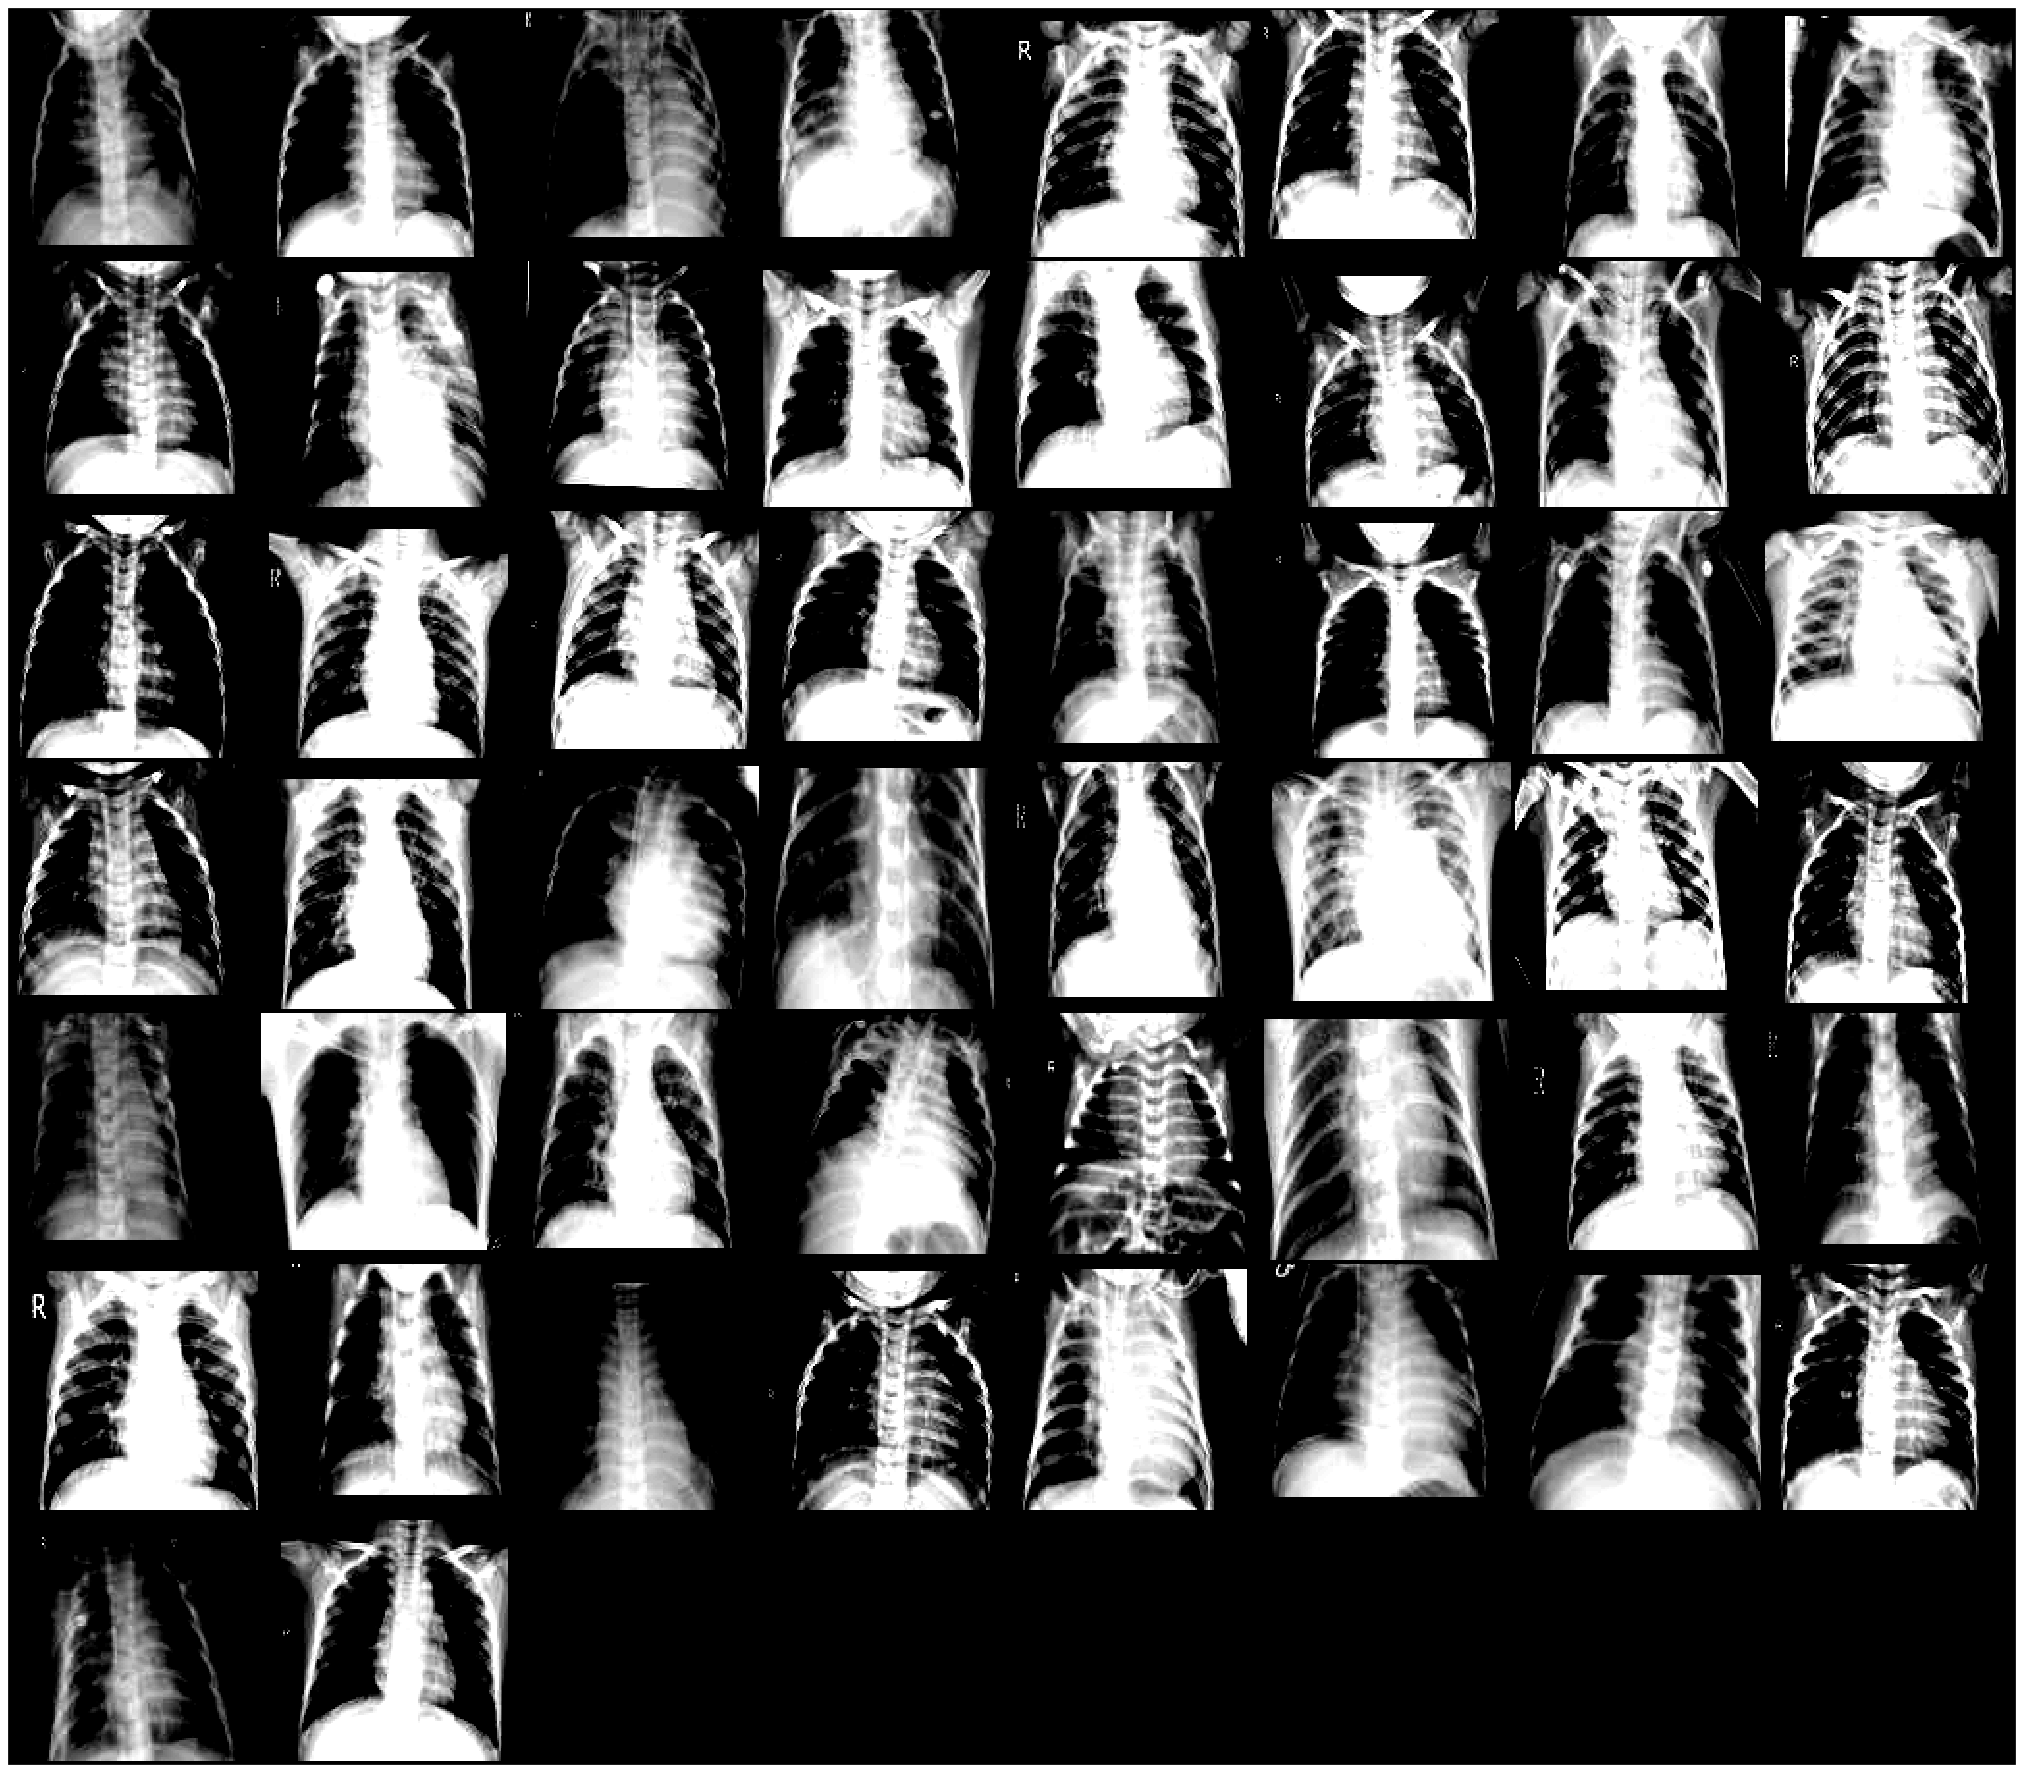

In [27]:
show_batch(train_dl)

In [28]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cuda')

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [31]:

class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input


In [32]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([50, 3, 128, 128])


In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [34]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.conv5 = conv_block(512, 1024, pool=True)
        self.conv6 = conv_block(1024, 1024, pool=True)
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(1024, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)  + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)  + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out)  + out
        out = self.classifier(out)
        return out

In [35]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
torch.cuda.empty_cache()
for images, labels in valid_dl:
    print(images.shape)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

torch.Size([24, 3, 128, 128])


## Training the model

In [38]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3033859729766846, 'val_acc': 0.0}]

In [39]:
epochs = 70
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [40]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)



Epoch [0], last_lr: 0.00045, train_loss: 0.9673, val_loss: 1.2608, val_acc: 0.5833
Epoch [1], last_lr: 0.00061, train_loss: 0.6159, val_loss: 1.7108, val_acc: 0.5833
Epoch [2], last_lr: 0.00087, train_loss: 0.6064, val_loss: 1.2083, val_acc: 0.4583
Epoch [3], last_lr: 0.00123, train_loss: 0.5804, val_loss: 0.9536, val_acc: 0.6667
Epoch [4], last_lr: 0.00168, train_loss: 0.6106, val_loss: 1.4306, val_acc: 0.5000
Epoch [5], last_lr: 0.00220, train_loss: 0.6820, val_loss: 2.0279, val_acc: 0.4167
Epoch [6], last_lr: 0.00279, train_loss: 0.6403, val_loss: 1.7023, val_acc: 0.4167
Epoch [7], last_lr: 0.00344, train_loss: 0.7106, val_loss: 1.5528, val_acc: 0.3750
Epoch [8], last_lr: 0.00413, train_loss: 0.6753, val_loss: 2.2758, val_acc: 0.2917
Epoch [9], last_lr: 0.00484, train_loss: 0.6208, val_loss: 2.0259, val_acc: 0.5000
Epoch [10], last_lr: 0.00555, train_loss: 0.6312, val_loss: 1.8181, val_acc: 0.3333
Epoch [11], last_lr: 0.00626, train_loss: 0.7198, val_loss: 1.4597, val_acc: 0.5000
Ep

In [41]:
a=input('type the time and then proceed')

type the time and then proceed50min 27s


In [42]:
train_time=a

In [43]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

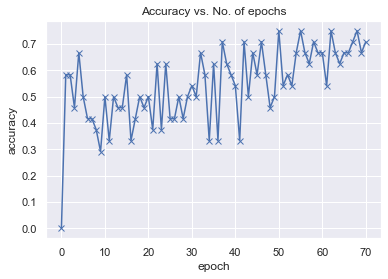

In [44]:
plot_accuracies(history)

In [45]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

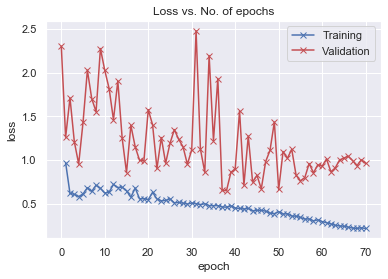

In [46]:
plot_losses(history)

In [47]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

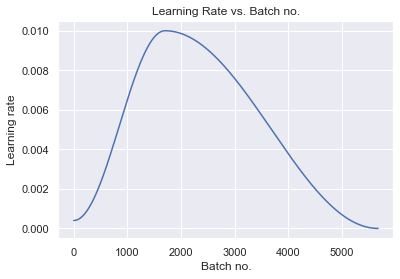

In [48]:
plot_lrs(history)

## Testing the model

In [49]:
def test_stats():
    stats = evaluate(model, test_dl)
    print('The Test Loss is :- '+str(stats['val_loss']))
    print('The Test Accuracy is :- '+ str(stats['val_acc']))

In [50]:
test_stats()

The Test Loss is :- 0.9028518199920654
The Test Accuracy is :- 0.7446154356002808


In [51]:
test_folder = ImageFolder(data_dir+'\\test',transform=ToTensor())

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

first={}
for index in range(len(test_dataset)):
    image,label =test_dataset[index]
    if label in first.keys():
        continue
    else:
        first[label]=index
    
first   

{0: 0, 1: 242, 2: 476}

Label: BACTERIA_PNEUMONIA , Predicted: BACTERIA_PNEUMONIA


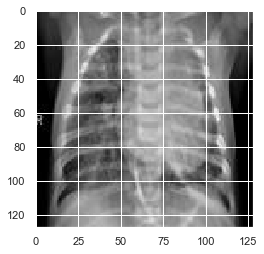

In [52]:
transformed_img, label = test_dataset[0]
untransformed_img,label = test_folder[0]
plt.imshow(untransformed_img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(transformed_img, model))

Label: BACTERIA_PNEUMONIA , Predicted: BACTERIA_PNEUMONIA


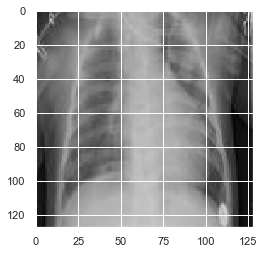

In [53]:
transformed_img, label = test_dataset[59]
untransformed_img,label = test_folder[59]
plt.imshow(untransformed_img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(transformed_img, model))

Label: NORMAL , Predicted: NORMAL


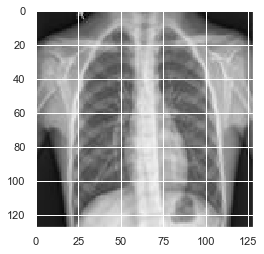

In [54]:
transformed_img, label = test_dataset[242]
untransformed_img,label = test_folder[242]
plt.imshow(untransformed_img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(transformed_img, model))

Label: VIRUS_PNEUMONIA , Predicted: VIRUS_PNEUMONIA


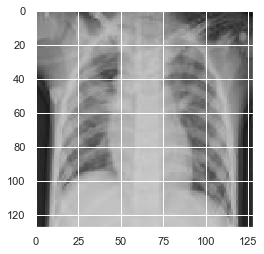

In [55]:
transformed_img, label = test_dataset[476]
untransformed_img,label = test_folder[476]
plt.imshow(untransformed_img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(transformed_img, model))

Label: NORMAL , Predicted: NORMAL


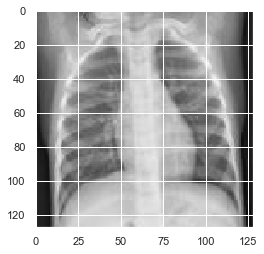

In [56]:
transformed_img, label = test_dataset[299]
untransformed_img,label = test_folder[299]
plt.imshow(untransformed_img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(transformed_img, model))

Label: VIRUS_PNEUMONIA , Predicted: VIRUS_PNEUMONIA


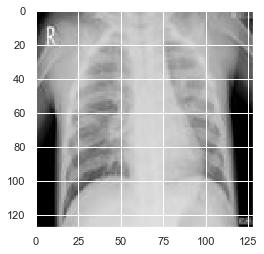

In [57]:
transformed_img, label = test_dataset[500]
untransformed_img,label = test_folder[500]
plt.imshow(untransformed_img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(transformed_img, model))

In [58]:
torch.save(model.state_dict(), 'C:\\Users\\pc\\DeepLearning\\Pytorch\\Course Project\\course-project-chest-x-ray\\cifar10-resnet9.pth')

In [59]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [60]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [61]:
jovian.commit(project=project_name, environment=None, outputs=['C:\\Users\\pc\\DeepLearning\\Pytorch\\Course Project\\course-project-chest-x-ray\\cifar10-resnet9.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "devindesilva123/course-project-chest-x-ray" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')")) (C:\Users\pc\DeepLearning\Pytorch\Course Project\course-project-chest-x-ray\cifar10-resnet9.pth)


[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/devindesilva123/course-project-chest-x-ray


'https://jovian.ml/devindesilva123/course-project-chest-x-ray'

### Deleting the files

This was done so that it is easier to re run the Notebook 

In [62]:
#deleting the files
shutil.rmtree('C:\\Users\\pc\\DeepLearning\\Pytorch\\Course Project\\course-project-chest-x-ray\\Data')
